In [2]:
# Import the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Import the data
data = pd.read_csv('Labelled Financial News.csv')

data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


Need to preprocess the data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk

# Download stopwords from NLTK
nltk.download('stopwords')

def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', str(text))
    # Tokenization
    tokens = text.split()
    # Lowercase conversion and stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Joining the processed words back into a string
    text = ' '.join(tokens)
    return text


# Apply preprocessing to each headline
data['Processed_Headlines'] = data['Sentence'].apply(preprocess_text)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['Processed_Headlines'], 
    data['Sentiment'], 
    test_size=0.2, 
    random_state=42
)

# Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Create a Logistic Regression model
logistic_regression = LogisticRegression()

# Create a pipeline that first vectorizes the text and then applies the classifier
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', logistic_regression)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))


[nltk_data] Downloading package stopwords to /home/calnan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

    negative       0.45      0.15      0.22       175
     neutral       0.71      0.90      0.79       622
    positive       0.75      0.65      0.70       372

    accuracy                           0.71      1169
   macro avg       0.64      0.57      0.57      1169
weighted avg       0.68      0.71      0.68      1169



In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define a Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Define a pipeline with TF-IDF and Gradient Boosting
pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', gradient_boosting)
])

# Define the hyperparameter space to search
param_grid = {
    'classifier__n_estimators': [100], # 200, 300],
    'classifier__learning_rate': [0.01],#, 0.1, 0.2],
    'classifier__max_depth': [3]#, 4, 5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline_gb, param_grid, cv=2, verbose=1, scoring='f1_macro', n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found:\n', grid_search.best_params_)

# Best score
print('Best score found:', grid_search.best_score_)

# Evaluate on the test set
best_gb_model = grid_search.best_estimator_
predictions_gb = best_gb_model.predict(X_test)
print(classification_report(y_test, predictions_gb))


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:
 {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best score found: 0.35915735256968784
              precision    recall  f1-score   support

    negative       0.67      0.02      0.04       175
     neutral       0.58      0.99      0.73       622
    positive       0.75      0.22      0.33       372

    accuracy                           0.60      1169
   macro avg       0.67      0.41      0.37      1169
weighted avg       0.65      0.60      0.50      1169



Accuracy: of negative is quite bad, so i'll try a different approach

In [6]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
import nltk

# Download required NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

# Assuming your dataframe is named 'data' and the text column is named 'Headlines'
# You will need to adjust these if your dataframe or column has a different name

# Your provided stopwords list
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']



# Preprocessing function
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(urlPattern, 'URL', tweet)
        tweet = re.sub(userPattern, 'USER', tweet)        
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        # Remove stopwords using a list of stopwords
        
        

        tweetwords = ''
        for word in tweet.split():
            if len(word) > 1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word + ' ')
            
        processedText.append(tweetwords)
        
    return processedText

# Process the text and time the operation
import time
t = time.time()

# Assuming 'Headlines' is the column with text data
data['Processed_Headlines'] = preprocess(data['Sentence'])

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')


[nltk_data] Downloading package wordnet to /home/calnan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/calnan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Text Preprocessing complete.
Time Taken: 1 seconds


In [7]:
data.head()

,Sentence,Sentiment,Processed_Headlines
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi on low down 50 to 50 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter of 2010 componenta net sa...
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnish russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm ha sold it remaining 2...


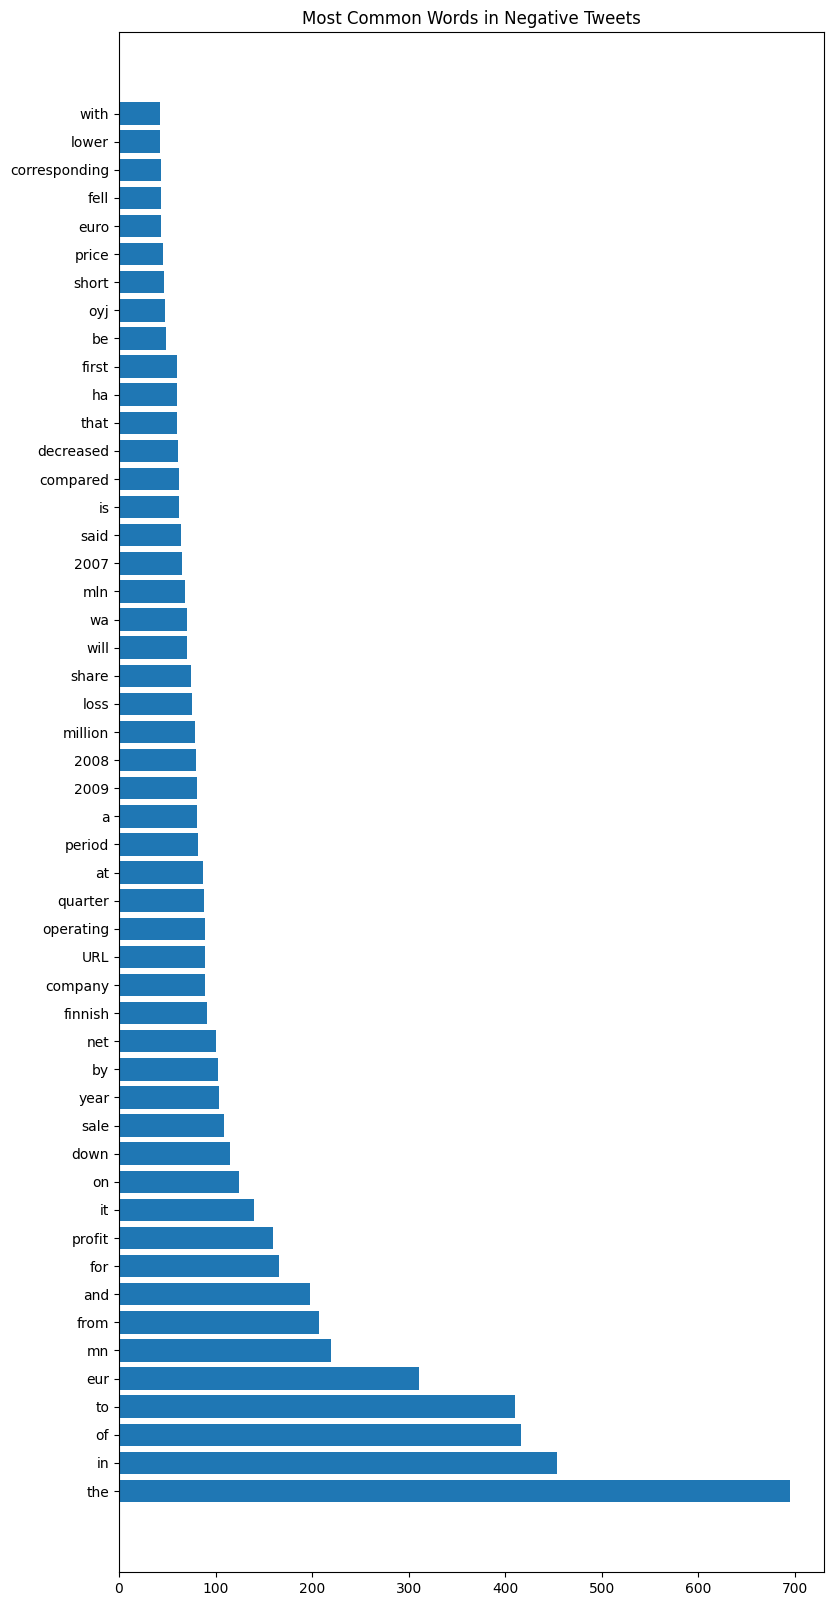

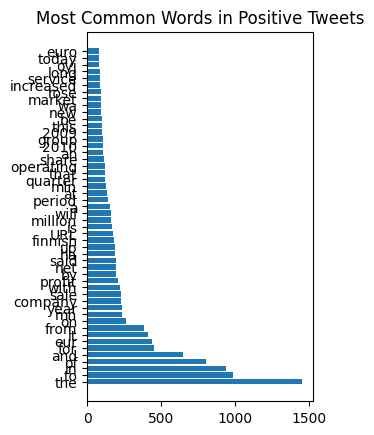

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# get the negative sentiment headlines
data_neg = data[data['Sentiment'] == 'negative']['Processed_Headlines']

# Assuming data_neg is a Series with preprocessed text
words_neg = " ".join(data_neg).split()
word_counts_neg = Counter(words_neg)



# Generate a simple frequency plot for the negative words
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)  # Negative sentiment
most_common_neg = word_counts_neg.most_common(50)
words, counts = zip(*most_common_neg)
plt.barh(words, counts)
plt.title('Most Common Words in Negative Tweets')



plt.show()

# get the positive sentiment headlines
data_pos = data[data['Sentiment'] == 'positive']['Processed_Headlines']

# Similarly for positive words, if needed
words_pos = " ".join(data_pos).split()
word_counts_pos = Counter(words_pos)

plt.subplot(1, 2, 2)  # Positive sentiment
most_common_pos = word_counts_pos.most_common(50)
words, counts = zip(*most_common_pos)
plt.barh(words, counts)
plt.title('Most Common Words in Positive Tweets')

plt.show()

In [9]:
data.head()

,Sentence,Sentiment,Processed_Headlines
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi on low down 50 to 50 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter of 2010 componenta net sa...
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnish russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm ha sold it remaining 2...


In [10]:
from sklearn.model_selection import train_test_split

# Find the number of instances of the smallest class
min_class_size = data['Sentiment'].value_counts().min()

# Resample each class to have the same number of instances
data_balanced = pd.concat([
    data[data['Sentiment'] == 'neutral'].sample(n=min_class_size, random_state=42),
    data[data['Sentiment'] == 'positive'].sample(n=min_class_size, random_state=42),
    data[data['Sentiment'] == 'negative'].sample(n=min_class_size, random_state=42)
])

# Now perform a stratified split
X_train, X_test, y_train, y_test = train_test_split(
    data_balanced['Processed_Headlines'],
    data_balanced['Sentiment'],
    test_size=0.1,
    random_state=0,
    stratify=data_balanced['Sentiment']  # Ensure stratification
)

print('Data Split done. The class distribution should now be equal.')


Data Split done. The class distribution should now be equal.


In [11]:
# Check class distribution in the training set
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

# Check class distribution in the test set
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
Sentiment
negative    0.333333
neutral     0.333333
positive    0.333333
Name: proportion, dtype: float64

Test set class distribution:
Sentiment
neutral     0.333333
negative    0.333333
positive    0.333333
Name: proportion, dtype: float64


In [12]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative', 'Neutral', 'Positive']  # Update categories
    group_names = ['True Neg','False Neu', 'False Pos', 
                   'False Neg','True Neu', 'False Pos', 
                   'False Neg', 'False Neu', 'True Pos']  # Update for 3x3 matrix

    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(3,3)  # Reshape for 3x3 matrix

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues', fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show()


              precision    recall  f1-score   support

    negative       0.59      0.76      0.66        86
     neutral       0.71      0.64      0.67        86
    positive       0.74      0.60      0.67        86

    accuracy                           0.67       258
   macro avg       0.68      0.67      0.67       258
weighted avg       0.68      0.67      0.67       258



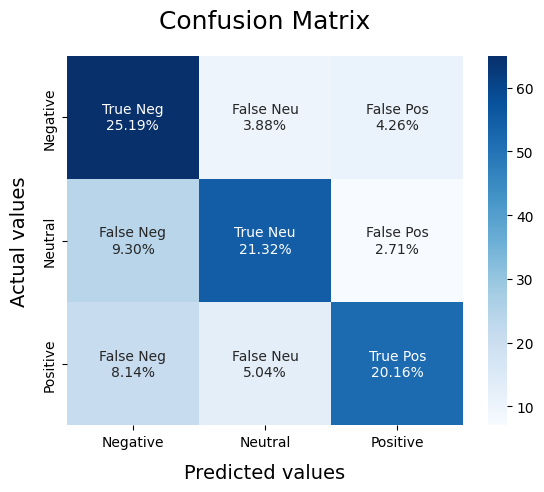

In [13]:
# Need to vectorize the text first
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

# Create a TF-IDF Vectorizer instance
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)

# Create the Bernoulli Naive Bayes model with alpha = 2
BNBmodel = BernoulliNB(alpha=2)

# Create a pipeline that first vectorizes the text and then applies the classifier
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', BNBmodel)
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
model_Evaluate(pipeline)  # Pass the entire pipeline to the evaluation function


# 57
# 68
# 69

              precision    recall  f1-score   support

    negative       0.64      0.57      0.60        86
     neutral       0.61      0.77      0.68        86
    positive       0.74      0.64      0.69        86

    accuracy                           0.66       258
   macro avg       0.67      0.66      0.66       258
weighted avg       0.67      0.66      0.66       258



/home/calnan/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


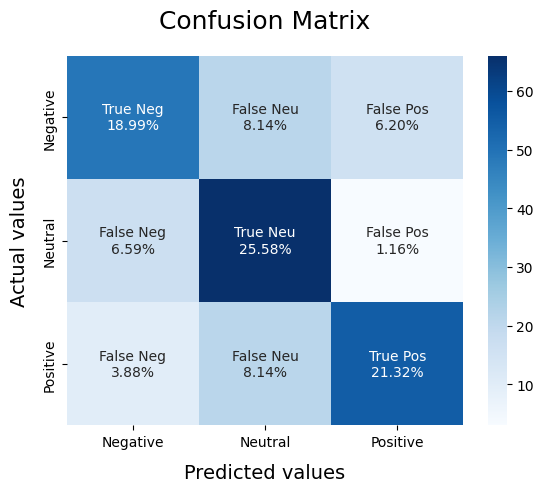

In [14]:
from sklearn.svm import LinearSVC

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)


svc_model = LinearSVC()

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', svc_model)
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
model_Evaluate(pipeline)  # Pass the entire pipeline to the evaluation function

              precision    recall  f1-score   support

    negative       0.66      0.62      0.64        86
     neutral       0.65      0.79      0.71        86
    positive       0.77      0.65      0.70        86

    accuracy                           0.69       258
   macro avg       0.69      0.69      0.68       258
weighted avg       0.69      0.69      0.68       258



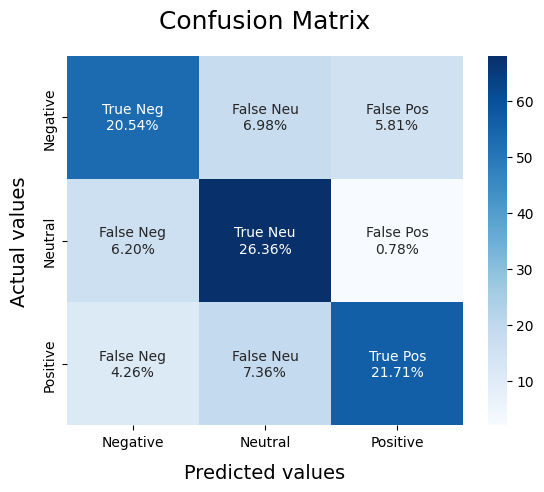

In [15]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 20), max_features=50000)


pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', lr_model)
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
model_Evaluate(pipeline)  # Pass the entire pipeline to the evaluation function

# Best
# 68
# 60
# 75

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 2); total time=   0.1s
[CV] END clf__C=0.01, vect__max_df=0.5, vect__max_features=5000, vect__ngram_range=(1, 2); total time=   0.1s
[CV] END c

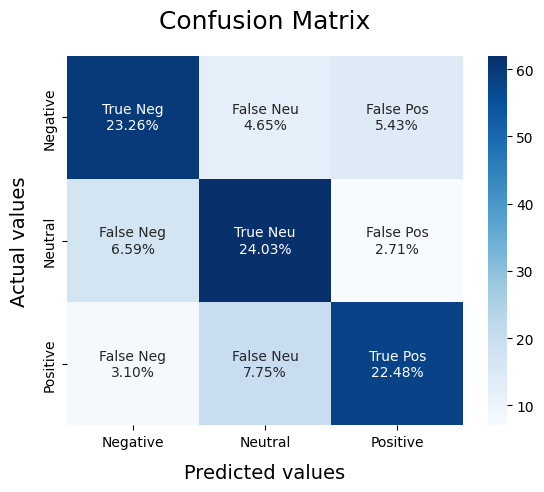

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define a pipeline with CountVectorizer and Logistic Regression
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(solver='liblinear')),  # solver is specified for smaller datasets
])


# Define the hyperparameters search space
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1,1), (1,2)),  # unigrams or bigrams
    'vect__max_features': (None, 5000, 10000),
    'clf__C': (0.01, 0.1, 1, 10),
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print out the best hyperparameters
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Evaluate the best grid search pipeline on the test data
model_Evaluate(grid_search.best_estimator_)


In [17]:
!pip install hyperopt

In [18]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the hyperparameters search space
space = {
    'C': hp.uniform('C', 0.01, 10),
    'max_features': hp.choice('max_features', [None, 5000, 10000]),
    'ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2)]),
    'max_df': hp.uniform('max_df', 0.5, 1.0),
}

# Objective function to minimize
def objective(params):
    # Create the TF-IDF vectorizer with parameters
    tfidf_vectorizer = TfidfVectorizer(max_features=params['max_features'], 
                                       ngram_range=params['ngram_range'],
                                       max_df=params['max_df'])
    
    # Transform the text data
    X_train_transformed = tfidf_vectorizer.fit_transform(X_train)
    
    # Create Logistic Regression model with parameters
    model = LogisticRegression(C=params['C'], max_iter=1000)
    
    # Calculate cross-validated accuracy
    score = cross_val_score(model, X_train_transformed, y_train, scoring='accuracy', cv=5, n_jobs=-1).mean()
    
    # Since we want to minimize, we return the negative of the accuracy
    return {'loss': -score, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best: {}".format(best))


100%|██████████| 10/10 [00:03<00:00,  2.64trial/s, best loss: -0.6602113459399332]
Best: {'C': 0.7981423112149784, 'max_df': 0.9369705411662307, 'max_features': 2, 'ngram_range': 1}


              precision    recall  f1-score   support

    negative       0.70      0.66      0.68        86
     neutral       0.66      0.76      0.70        86
    positive       0.74      0.66      0.70        86

    accuracy                           0.69       258
   macro avg       0.70      0.69      0.69       258
weighted avg       0.70      0.69      0.69       258



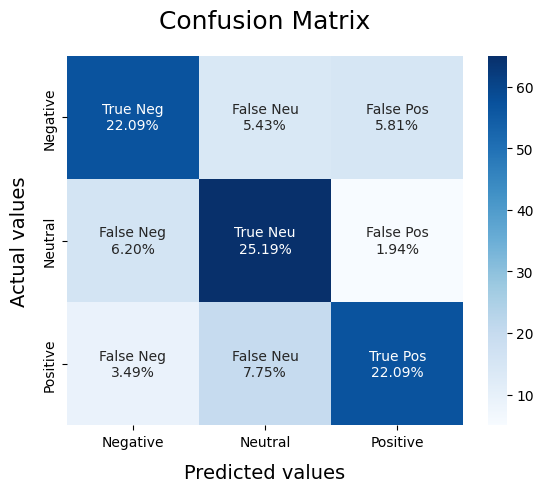

In [19]:
# Rebuild the pipeline with the obtained hyperparameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, 
                              max_features=None,
                              ngram_range=(1, 1))),
    ('clf', LogisticRegression(C=0.7094030958871773, max_iter=1000))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Evaluate the model with the custom evaluation function
model_Evaluate(pipeline)

# 70
# 66
# 74


In [20]:
!pip install pickle5

In [21]:
# Save the model as a pickle file
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [22]:
!pip install transformers torch


In [23]:
data = data.reset_index(drop=True)


data.head()

,Sentence,Sentiment,Processed_Headlines
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi on low down 50 to 50 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter of 2010 componenta net sa...
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnish russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm ha sold it remaining 2...


In [24]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

data.head()

,Sentence,Sentiment,Processed_Headlines
0,The GeoSolutions technology will leverage Bene...,2,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0,esi on low down 50 to 50 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",2,for the last quarter of 2010 componenta net sa...
3,According to the Finnish-Russian Chamber of Co...,1,according to the finnish russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,1,the swedish buyout firm ha sold it remaining 2...


In [25]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Processed_Headlines'], data['Sentiment'], test_size=0.2)


In [26]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


/home/calnan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-12 14:50:09.498145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 14:50:09.529992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 14:50:09.530817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 14:50:10.056619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [27]:
print("Length of train input_ids:", len(train_encodings['input_ids']))
print("Length of train labels:", len(train_labels))
print("Length of test input_ids:", len(test_encodings['input_ids']))
print("Length of test labels:", len(test_labels))

Length of train input_ids: 4673
Length of train labels: 4673
Length of test input_ids: 1169
Length of test labels: 1169


In [28]:
assert len(train_encodings['input_ids']) == len(train_labels)
assert len(test_encodings['input_ids']) == len(test_labels)


In [29]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        try:
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        except Exception as e:
            raise ValueError(f"Error in __getitem__ at index {idx}: {str(e)}")

    def __len__(self):
        return len(self.labels)




train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)


In [30]:
# Check for consistency in train dataset
if not all(idx in range(len(train_dataset)) for idx in range(len(train_dataset))):
    print("Inconsistent indices in train dataset")

# Check for consistency in test dataset
if not all(idx in range(len(test_dataset)) for idx in range(len(test_dataset))):
    print("Inconsistent indices in test dataset")


In [31]:
problematic_index = 1027  # or any index where the error occurs
try:
    problematic_encoding = {key: val[problematic_index] for key, val in train_encodings.items()}
    print("Problematic encoding:", problematic_encoding)
except Exception as e:
    print(f"Error with encoding at index {problematic_index}: {e}")


Problematic encoding: {'input_ids': [101, 6983, 2009, 24853, 2938, 8067, 9123, 1051, 2100, 3501, 2056, 2006, 2281, 2410, 2294, 2008, 15723, 5302, 8840, 10695, 29278, 2015, 2165, 2039, 1996, 2597, 1997, 5766, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
if problematic_index < len(data):
    print("Data at problematic index:", data.iloc[problematic_index])
else:
    print(f"Index {problematic_index} is out of range for the DataFrame.")


Data at problematic index: Sentence               Basware Corporation stock exchange release Aug...
Sentiment                                                              2
Processed_Headlines    basware corporation stock exchange release aug...
Name: 1027, dtype: object


In [33]:
from torch.utils.data import DataLoader

print(train_dataset)

for idx in range(len(train_dataset)):
    try:
        _ = train_dataset[idx]
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        break



Error at index 7: Error in __getitem__ at index 7: 7


In [34]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [36]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 4673
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 879
  Number of trainable parameters = 109484547


ValueError: Error in __getitem__ at index 3558: 3558

Old not working








.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [37]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import torch


# Assuming 'data' is your pandas DataFrame
# Let's encode the sentiment labels
label_dict = {'negative': -1, 'neutral': 0, 'positive': 1}
data['Sentiment'] = data['Sentiment'].replace(label_dict)

# Load the tokenizer

# train_data = train_data.reset_index(drop=True)
# val_data = val_data.reset_index(drop=True)


# Tokenization and encoding the dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        if index >= len(self.data):
            raise IndexError(f"Index {index} is out of bounds for DataFrame with length {len(self.data)}")

        sentence = str(self.data.iloc[index].Processed_Headlines)
        sentiment = int(self.data.iloc[index].Sentiment)
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(sentiment, dtype=torch.long)  # Use 'labels' for targets
        }

    def __len__(self):
        return len(self.data)

# Define dataset parameters
MAX_LEN = 64  # Maximum length of the tokens list
BATCH_SIZE = 16  # Batch size for training

# Create the dataset
dataset = SentimentDataset(data, tokenizer, MAX_LEN)

# Creating the dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

# Split the data
train_data, val_data = train_test_split(data, test_size=0.1)

# Reset index
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)


train_dataset = SentimentDataset(train_data, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_data, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [38]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
# Need to import AdamW from transformers and get_linear_schedule_with_warmup from transformers.optimization
from transformers import AdamW, get_linear_schedule_with_warmup

# Reset the index of your DataFrame
data = data.reset_index(drop=True)


# Load a lighter model: DistilBERT
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_dict))
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Proceed with the rest of your setup...


# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(),
                  lr=1e-5)  # You can adjust the learning rate
EPOCHS = 3  # You can adjust this

# Total number of training steps
total_steps = len(dataloader) * EPOCHS

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Define the training loop
def train(model, dataloader):
    model.train()

    total_loss, total_accuracy = 0, 0
    total_steps = len(dataloader)
    print_every = total_steps // 1  # Print the progress every 10% of the batch
    
    print('Here ')

    for step, batch in enumerate(dataloader):
        print(f'Batch {step} of {total_steps}')
        # Load batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero out any previously calculated gradients
        model.zero_grad()

        # Perform a forward pass. This will return loss because 'labels' are provided
        outputs = model(input_ids=batch['input_ids'], 
                        attention_mask=batch['attention_mask'],
                        labels=batch['labels'])

        # Get the loss
        loss = outputs.loss
        total_loss += loss.item()

        # Perform a backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()

        # Print progress
        if step % print_every == 0 and step != 0:
            print(f' Batch {step} of {total_steps}, Loss: {loss.item()}')

    # Calculate the average loss over the entire training data
    avg_loss = total_loss / total_steps

    print(f'Training loss: {avg_loss}')



def validate(model, dataloader):
    model.eval()
    total_loss, total_accuracy = 0, 0

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Modify your training loop to include validation
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}/{EPOCHS}')
    train(model, train_dataloader)
    val_loss = validate(model, val_dataloader)
    print(f'Validation loss: {val_loss}')



loading configuration file config.json from cache at /home/calnan/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/calnan/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e9

EPOCH 1/3
Here 
Batch 0 of 329
Batch 1 of 329


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.71 GiB already allocated; 17.75 MiB free; 1.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def predict_sentiment_debug(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    return predicted_class, probabilities[0].cpu().numpy()

# Test the function on a sample
sample_text = "This is a positive news story about technology."
prediction, probs = predict_sentiment_debug(sample_text)
print(f"Predicted class: {prediction}, Probabilities: {probs}")


Predicted class: 0, Probabilities: [0. 0. 0.]


In [ ]:
# Check the balance of the classes in the training data
print(train_data['Sentiment'].value_counts())


Sentiment
 0    2817
 1    1652
-1     788
Name: count, dtype: int64


In [ ]:
# Save the model's state dictionary
model_save_path = 'distilbert_finetuned.pth'
torch.save(model.state_dict(), model_save_path)

# Optionally, you can save the entire model (but it will be a larger file)
# torch.save(model, 'distilbert_finetuned_full_model.pth')


In [ ]:
torch.save(model, 'distilbert_finetuned_full_model.pth')